In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the dataset
empData =  pd.read_excel("Data_Professional_Salary_Survey_Responses.xlsx")


In [3]:
print(empData.shape)
print(empData.info())
print(empData.describe())


(10341, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10341 entries, 0 to 10340
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Survey Year                           10341 non-null  int64         
 1   Timestamp                             10341 non-null  datetime64[ns]
 2   SalaryUSD                             10341 non-null  float64       
 3   Country                               10341 non-null  object        
 4   PostalCode                            8538 non-null   object        
 5   PrimaryDatabase                       10341 non-null  object        
 6   YearsWithThisDatabase                 10341 non-null  int64         
 7   OtherDatabases                        8397 non-null   object        
 8   EmploymentStatus                      10341 non-null  object        
 9   JobTitle                              10341 non-null  object

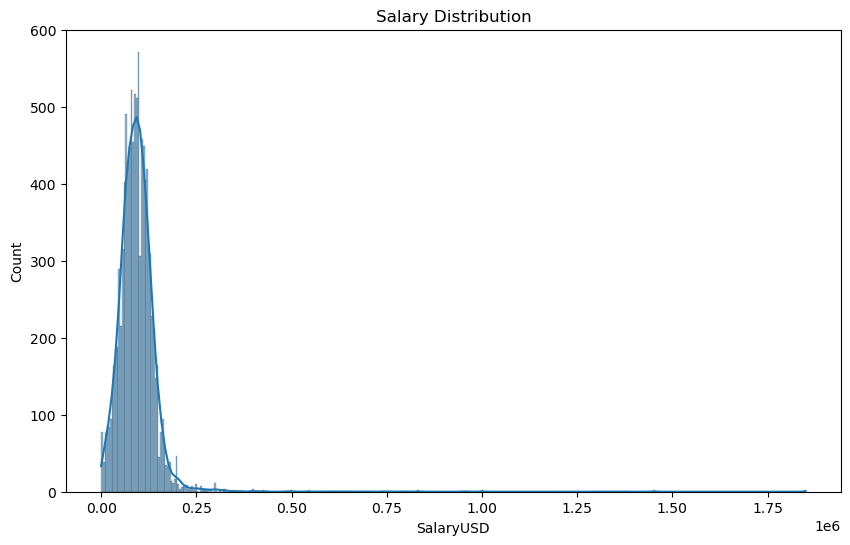

In [4]:
# Salary distribution
plt.figure(figsize=(10, 6))
sns.histplot(empData['SalaryUSD'], kde=True)
plt.title('Salary Distribution')
plt.show()

C:\Users\shels\AppData\Local\Temp\ipykernel_37780\667822744.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(empData.corr(), annot=True, cmap='coolwarm')


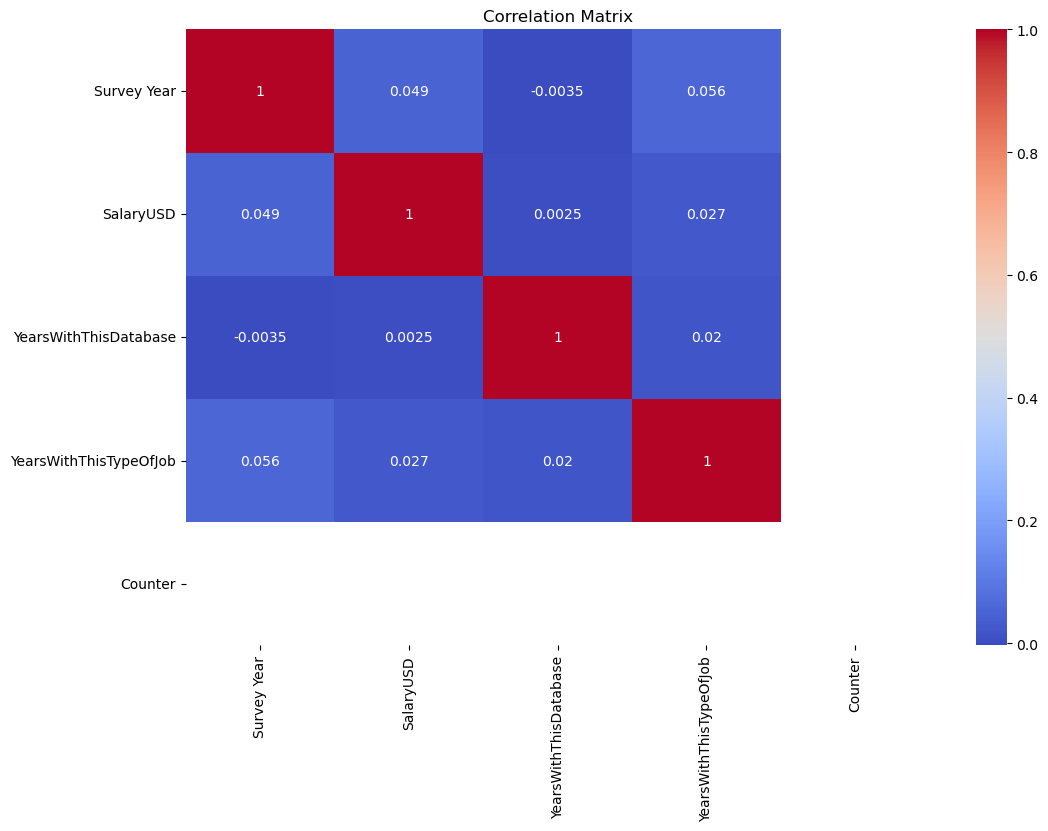

In [145]:
plt.figure(figsize=(12, 8))
sns.heatmap(empData.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### Updating the column values of some column values

In [5]:
# Shorten job titles using the replace function
empData['JobTitle'] = empData['JobTitle'].replace({
    'DBA \(Production Focus - build & troubleshoot.*\)': 'DBA (Production Focus)',
    'DBA \(General - splits time evenly between writing & tuning.*\)': 'DBA (General)',
    'DBA \(Development Focus - tunes queries, indexes, does deployments.*\)': 'DBA (Development Focus)',
    'Developer: Business Intelligence \(SSRS, PowerBI, etc\)': 'Developer: BI',
    'Developer: App code \(C#, JS, etc\)': 'Developer: App Code',
    'Developer: T-SQL': 'Developer: T-SQL',
    'DevOps, Sr Software Engineer DBA':'DevOps'
    
}, regex=True)

print(empData[['JobTitle']].head())

                 JobTitle
0           Developer: BI
1  DBA (Production Focus)
2           DBA (General)
3  DBA (Production Focus)
4           Developer: BI


In [6]:
empData['EmploymentStatus'] = empData['EmploymentStatus'].replace({
    'Full time employee of a consulting/contracting company': 'Consulting Full time employee',
    'Independent consultant, contractor, freelancer,  or company owner': 'Independent consultant',
    'Independent or freelancer or company owner': 'Independent consultant',
}, regex=False)
print(empData['EmploymentStatus'].head())

0    Full time employee
1    Full time employee
2    Full time employee
3    Full time employee
4    Full time employee
Name: EmploymentStatus, dtype: object


### Data Cleaning for 'HowManyCompanies' column

In [7]:
def preprocess_how_many_companies(col):
    col = col.str.extract('(\d+)', expand=False)  
    col = col.replace("Not Asked", np.nan)        
    col = col.fillna(0).astype(int)               
    return col

empData['HowManyCompanies'] = preprocess_how_many_companies(empData['HowManyCompanies'])


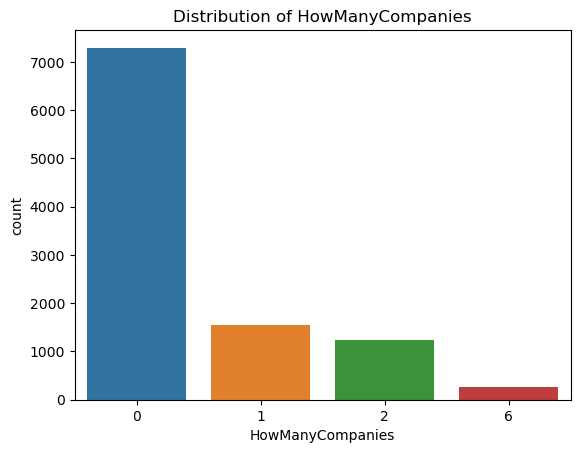

In [8]:
sns.countplot(x='HowManyCompanies', data=empData)
plt.title("Distribution of HowManyCompanies")
plt.show()

In [9]:
# Replace "None" with 0 and "More than 5" with 6
empData['OtherPeopleOnYourTeam'] = empData['OtherPeopleOnYourTeam'].replace({
    'None': 0,
    'More than 5': 6
}).astype(int)

print(empData['OtherPeopleOnYourTeam'])

0        0
1        0
2        1
3        0
4        0
        ..
10336    1
10337    5
10338    1
10339    1
10340    3
Name: OtherPeopleOnYourTeam, Length: 10341, dtype: int32


### Remove Irrelevant Columns

In [10]:
irrelevant_columns = [ 'Timestamp', 'PostalCode', 'Counter','NewestVersionInProduction','OldestVersionInProduction','PopulationOfLargestCityWithin20Miles','CareerPlansThisYear','CompanyEmployeesOverall']
empData = empData.drop(columns=irrelevant_columns)

In [11]:
empData.head()

,Survey Year,SalaryUSD,Country,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,ManageStaff,YearsWithThisTypeOfJob,HowManyCompanies,OtherPeopleOnYourTeam,EmploymentSector,Gender
0,2021,65000.0,Sweden,Microsoft SQL Server,4,Microsoft SQL Server,Full time employee,Developer: BI,Yes,4,1,0,Private business,Male
1,2021,145000.0,United States,Microsoft SQL Server,15,Azure SQL DB (any flavor),Full time employee,DBA (Production Focus),No,25,0,0,Private business,Male
2,2021,105000.0,United States,Microsoft SQL Server,12,"PostgreSQL, Azure SQL DB (any flavor)",Full time employee,DBA (General),Yes,6,0,1,Private business,Male
3,2021,46482.0,United Kingdom,Microsoft SQL Server,10,Azure SQL DB (any flavor),Full time employee,DBA (Production Focus),No,5,2,0,"Education (K-12, college, university)",Male
4,2021,98800.0,United States,Microsoft SQL Server,5,DB2,Full time employee,Developer: BI,No,5,1,0,Private business,Male


### Handle Missing Values

In [12]:
empData = empData.dropna()  

#### Check the count of null value

In [13]:
empData.isnull().sum()

Survey Year               0
SalaryUSD                 0
Country                   0
PrimaryDatabase           0
YearsWithThisDatabase     0
OtherDatabases            0
EmploymentStatus          0
JobTitle                  0
ManageStaff               0
YearsWithThisTypeOfJob    0
HowManyCompanies          0
OtherPeopleOnYourTeam     0
EmploymentSector          0
Gender                    0
dtype: int64

### Frequency of Job Titles

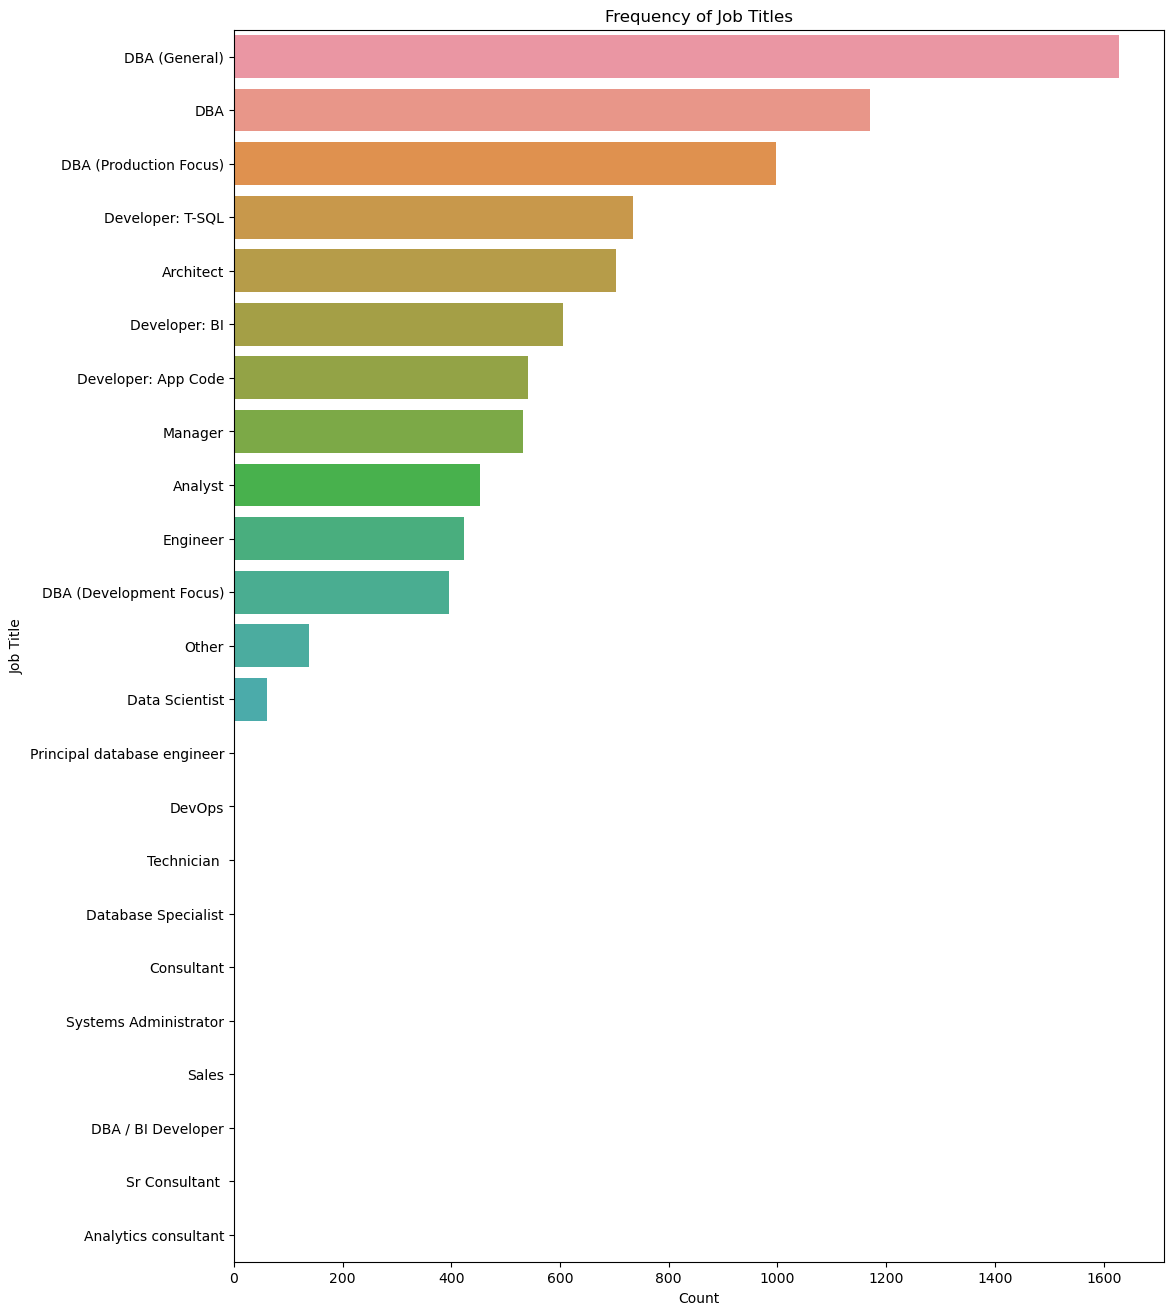

In [14]:
plt.figure(figsize=(12, 16))
sns.countplot(y='JobTitle', data=empData, order=empData['JobTitle'].value_counts().index)
plt.title('Frequency of Job Titles')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.show()

In [156]:
empData.head()

,Survey Year,SalaryUSD,Country,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,ManageStaff,YearsWithThisTypeOfJob,HowManyCompanies,OtherPeopleOnYourTeam,EmploymentSector,Gender
0,2021,65000.0,Sweden,Microsoft SQL Server,4,Microsoft SQL Server,Full time employee,Developer: BI,Yes,4,1,0,Private business,Male
1,2021,145000.0,United States,Microsoft SQL Server,15,Azure SQL DB (any flavor),Full time employee,DBA (Production Focus),No,25,0,0,Private business,Male
2,2021,105000.0,United States,Microsoft SQL Server,12,"PostgreSQL, Azure SQL DB (any flavor)",Full time employee,DBA (General),Yes,6,0,1,Private business,Male
3,2021,46482.0,United Kingdom,Microsoft SQL Server,10,Azure SQL DB (any flavor),Full time employee,DBA (Production Focus),No,5,2,0,"Education (K-12, college, university)",Male
4,2021,98800.0,United States,Microsoft SQL Server,5,DB2,Full time employee,Developer: BI,No,5,1,0,Private business,Male


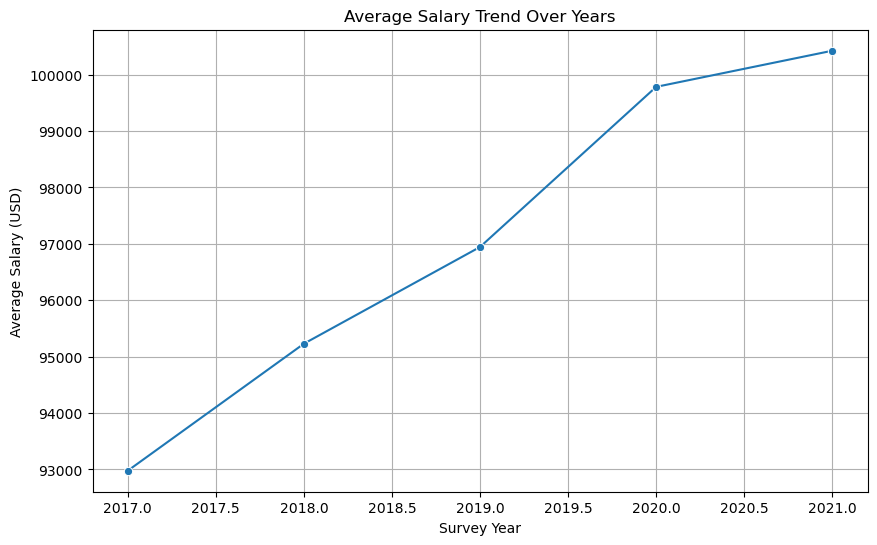

In [122]:
# Trend Identification plot
salary_trend = empData.groupby('Survey Year')['SalaryUSD'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(data=salary_trend, marker='o')
plt.title('Average Salary Trend Over Years')
plt.xlabel('Survey Year')
plt.ylabel('Average Salary (USD)')
plt.grid()
plt.show()

### Plot the visual - salaries vary by employment status across different years

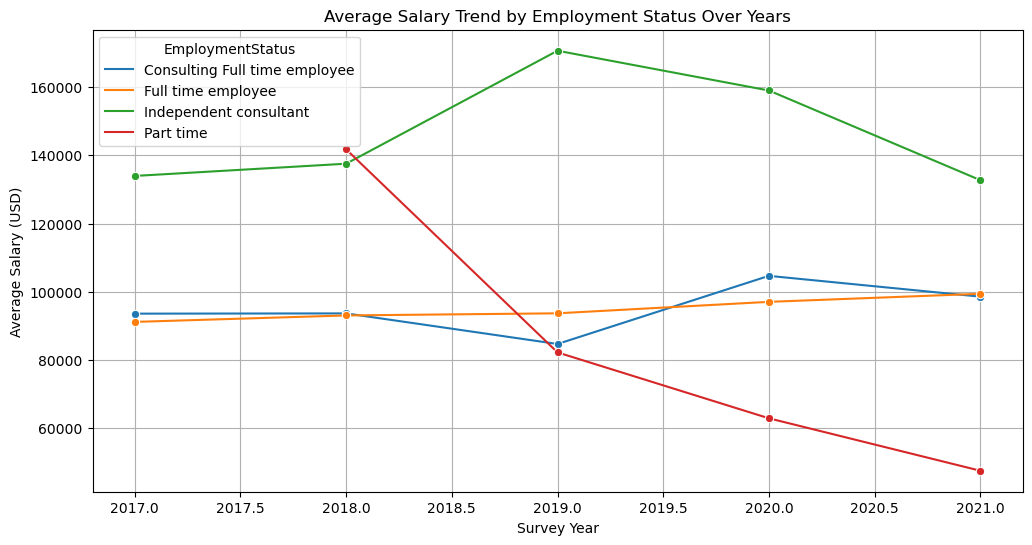

In [123]:
# Group by 'Survey Year' and 'EmploymentStatus' and calculate the average salary
status_salary_trend = empData.groupby(['Survey Year', 'EmploymentStatus'])['SalaryUSD'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Survey Year', y='SalaryUSD', hue='EmploymentStatus', data=status_salary_trend, marker='o')
plt.title('Average Salary Trend by Employment Status Over Years')
plt.xlabel('Survey Year')
plt.ylabel('Average Salary (USD)')
plt.grid()
plt.show()

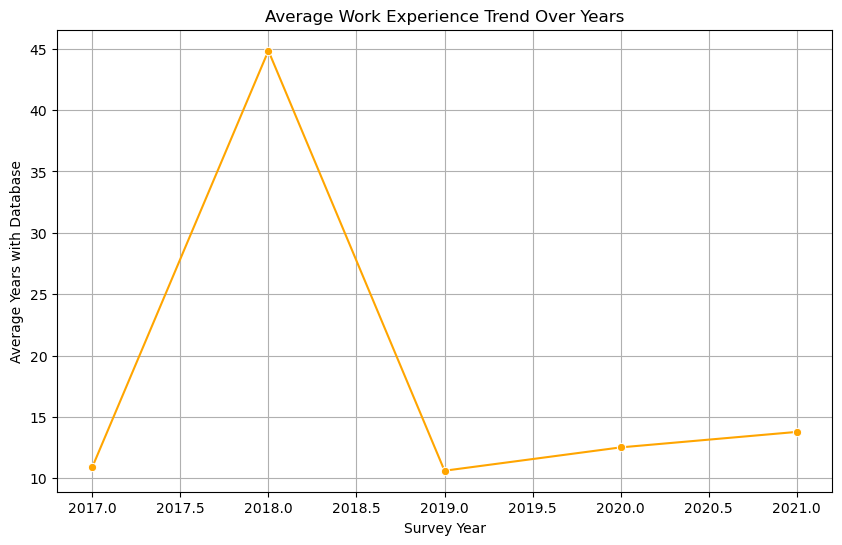

In [124]:
# Group by 'Survey Year' and calculate the average years with the database
experience_trend = empData.groupby('Survey Year')['YearsWithThisDatabase'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=experience_trend, marker='o', color='orange')
plt.title('Average Work Experience Trend Over Years')
plt.xlabel('Survey Year')
plt.ylabel('Average Years with Database')
plt.grid()
plt.show()


### Visualisation- Focus on up to 100 years of experience

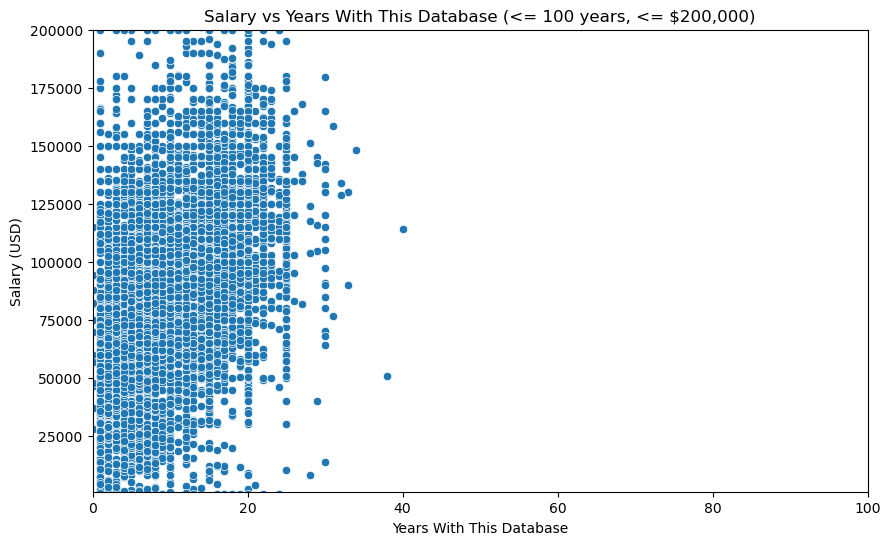

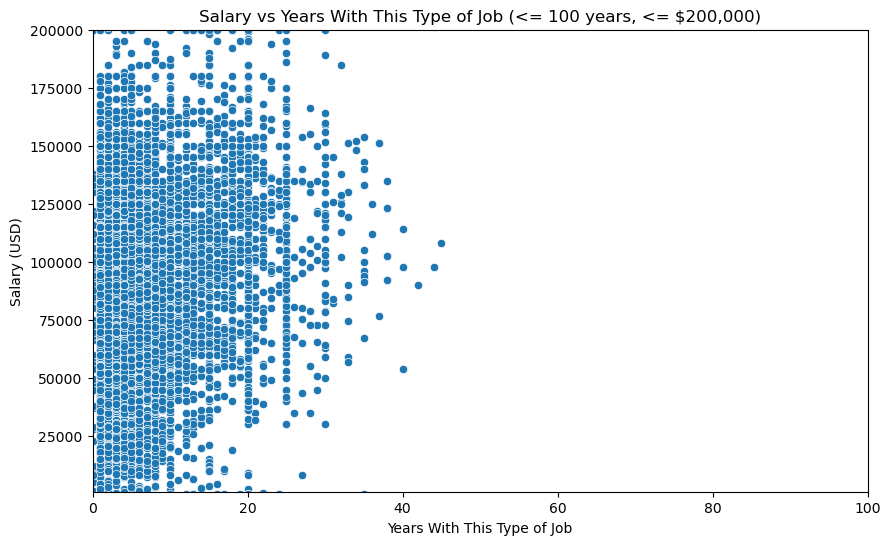

In [125]:
# Filtering for smaller ranges
filtered_df = empData[(empData['SalaryUSD'] <= 2000000) & (empData['YearsWithThisDatabase'] <= 100)]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='YearsWithThisDatabase', y='SalaryUSD', data=filtered_df)
plt.title('Salary vs Years With This Database (<= 100 years, <= $200,000)')
plt.xlabel('Years With This Database')
plt.ylabel('Salary (USD)')
plt.xlim(0, 100)  # Focus on up to 20 years of experience
plt.ylim(1000, 200000)  # Focus on salaries between 50k and 200k
plt.show()


# Filtering for smaller ranges
filtered_df = empData[(empData['SalaryUSD'] <= 2000000) & (empData['YearsWithThisTypeOfJob'] <= 100)]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='YearsWithThisTypeOfJob', y='SalaryUSD', data=filtered_df)
plt.title('Salary vs Years With This Type of Job (<= 100 years, <= $200,000)')
plt.xlabel('Years With This Type of Job')
plt.ylabel('Salary (USD)')
plt.xlim(0, 100)  
plt.ylim(1000, 200000)  
plt.show()




### Salary by Job Title, Location, and Gender (Focused on Salaries <= $200,000)

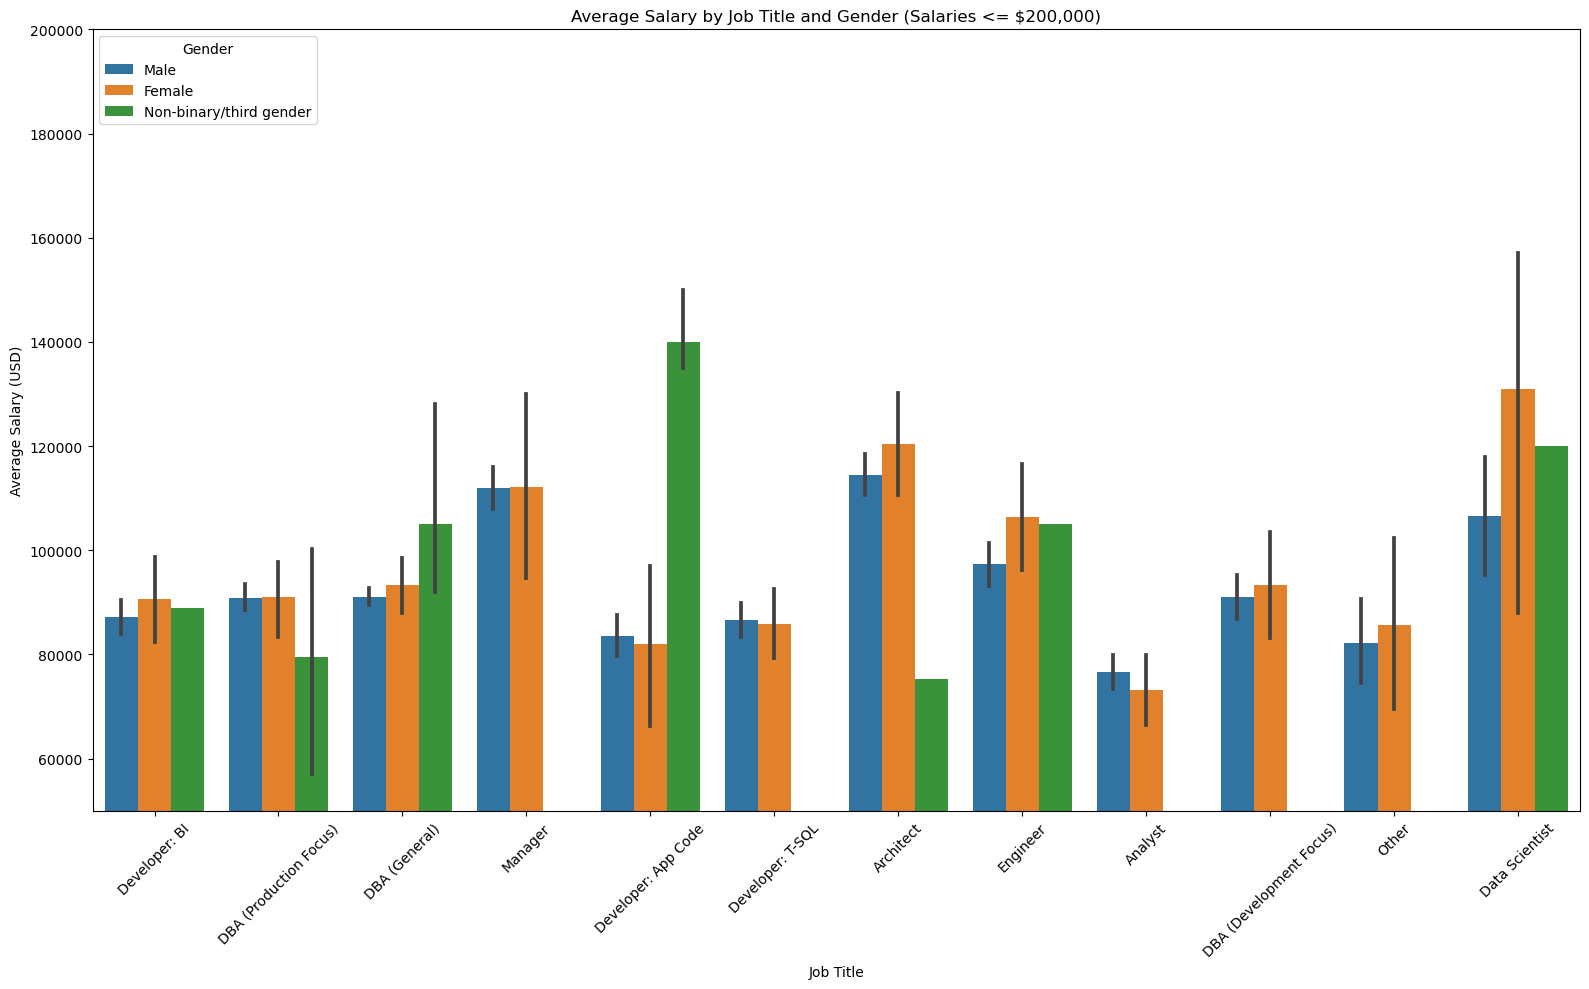

In [126]:
filtered_df = empData[(empData['SalaryUSD'] <= 200000) & (empData['Gender'] != 'Not Asked') & (empData['Gender'] != 'Prefer not to say') & (empData['Gender'] != 'None')]

# Create the plot
plt.figure(figsize=(16, 10))
sns.barplot(x='JobTitle', y='SalaryUSD', hue='Gender', data=filtered_df)
plt.title('Average Salary by Job Title and Gender (Salaries <= $200,000)')
plt.xlabel('Job Title')
plt.ylabel('Average Salary (USD)')
plt.xticks(rotation=45)
plt.ylim(50000, 200000) 
plt.tight_layout()  
plt.show()


### Salary by Job Title, Location, and Gender (Focused on Salaries >= $200,000)

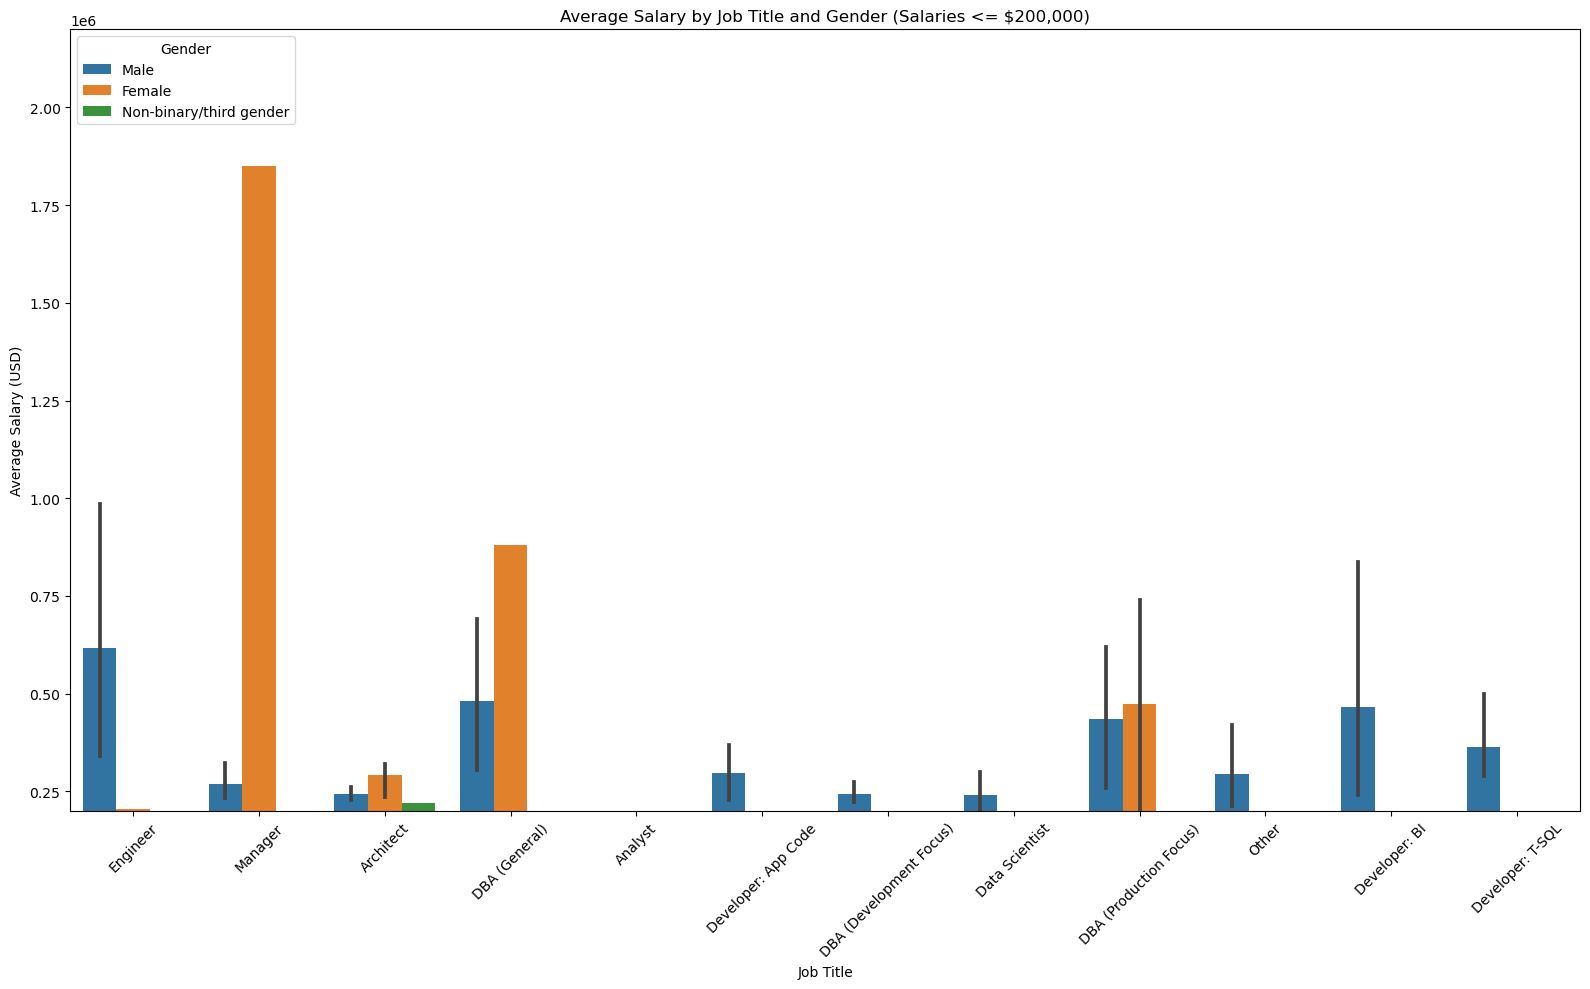

In [127]:
filtered_df = empData[(empData['SalaryUSD'] >= 200000) & (empData['Gender'] != 'Not Asked') & (empData['Gender'] != 'Prefer not to say') & (empData['Gender'] != 'None')]

# Create the plot
plt.figure(figsize=(16, 10))
sns.barplot(x='JobTitle', y='SalaryUSD', hue='Gender', data=filtered_df)
plt.title('Average Salary by Job Title and Gender (Salaries <= $200,000)')
plt.xlabel('Job Title')
plt.ylabel('Average Salary (USD)')
plt.xticks(rotation=45)
plt.ylim(200000, 2200000) 
plt.tight_layout()  
plt.show()

### Remove the outliers

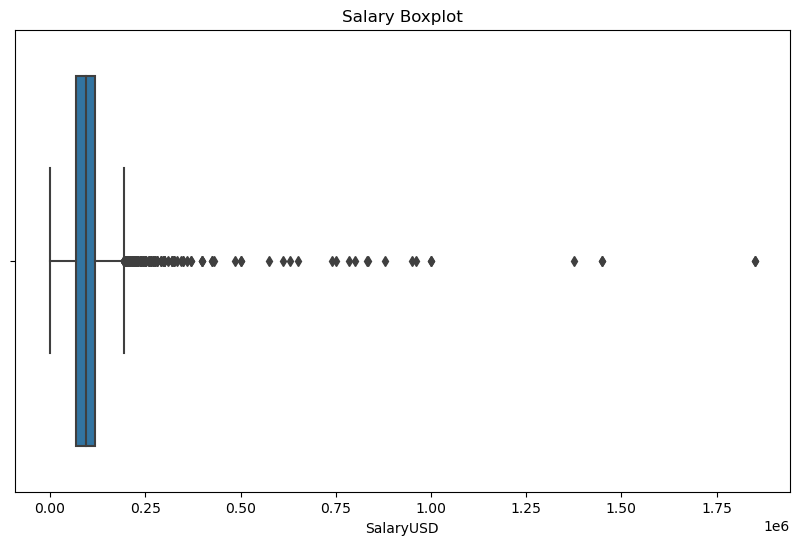

In [157]:
# Boxplot to check outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=empData['SalaryUSD'])
plt.title('Salary Boxplot')
plt.show()

In [15]:
q1 = empData['SalaryUSD'].quantile(0.25)
q3 = empData['SalaryUSD'].quantile(0.75)
iqr = q3 - q1
empData = empData[(empData['SalaryUSD'] >= q1 - 1.5 * iqr) & (empData['SalaryUSD'] <= q3 + 1.5 * iqr)]


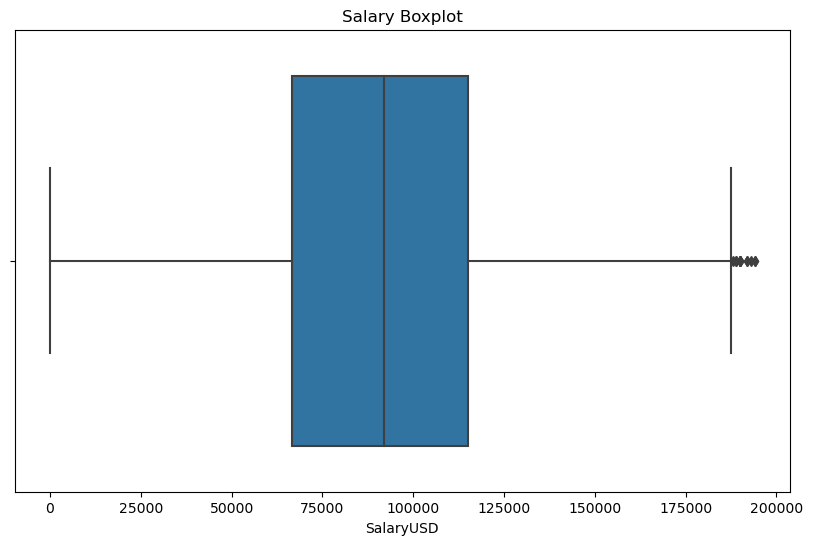

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=empData['SalaryUSD'])
plt.title('Salary Boxplot')
plt.show()

### Feature Engineering

#### Encode Categorical Features

In [17]:
label_encoders = {}
for column in ['PrimaryDatabase', 'JobTitle', 'EmploymentStatus', 'EmploymentSector', 'Gender','Country','OtherDatabases','ManageStaff']:
    le = LabelEncoder()
    empData[column] = le.fit_transform(empData[column])
    label_encoders[column] = le


In [18]:
empData.head()

,Survey Year,SalaryUSD,Country,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,ManageStaff,YearsWithThisTypeOfJob,HowManyCompanies,OtherPeopleOnYourTeam,EmploymentSector,Gender
0,2021,65000.0,78,6,4,174,1,13,1,4,1,0,4,1
1,2021,145000.0,88,6,15,11,1,7,0,25,0,0,4,1
2,2021,105000.0,88,6,12,1715,1,6,1,6,0,1,4,1
3,2021,46482.0,87,6,10,11,1,7,0,5,2,0,0,1
4,2021,98800.0,88,6,5,63,1,13,0,5,1,0,4,1


In [19]:
print(empData['ManageStaff'])

0        1
1        0
2        1
3        0
4        0
        ..
10335    0
10337    1
10338    0
10339    0
10340    0
Name: ManageStaff, Length: 8209, dtype: int32


### Feature Scaling

In [20]:
scaler = StandardScaler()
empData[['SalaryUSD']] = scaler.fit_transform(empData[['SalaryUSD']])


In [21]:
print(empData[['SalaryUSD']])

       SalaryUSD
0      -0.723734
1       1.490812
2       0.383539
3      -1.236347
4       0.211912
...          ...
10335  -0.059370
10337  -0.723734
10338  -0.170098
10339  -0.031689
10340  -1.886372

[8209 rows x 1 columns]


### Feature Selection

In [22]:
X = empData.drop('SalaryUSD', axis=1)
y = empData['SalaryUSD']

# Train a model to get feature importance
model = RandomForestRegressor()
model.fit(X, y)

# Get importance scores
importance = model.feature_importances_
features = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
features = features.sort_values(by='Importance', ascending=False)
top_features = features[features['Importance'] > 0.01]['Feature'].tolist()
X = X[top_features]


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)


MAE: 0.4900918797673079
MSE: 0.4441081670415926


### Improving Model Performance

In [24]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the tuned model
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)

print("Best MAE:", mae_best)
print("Best MSE:", mse_best)


Best MAE: 0.4858975497324624
Best MSE: 0.4348659153114943


### Decoding Columns Back to Initial Data Types

In [31]:
for column, le in label_encoders.items():
    empData[column] = le.inverse_transform(empData[column])


In [32]:
# Inverse transform the scaled predictions and actual test values
y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Create the results DataFrame with decoded salaries
results = X_test.copy()
results['Actual Salary'] = y_test_original
results['Predicted Salary'] = y_pred_original

In [33]:
empData.head()

,Survey Year,SalaryUSD,Country,PrimaryDatabase,YearsWithThisDatabase,OtherDatabases,EmploymentStatus,JobTitle,ManageStaff,YearsWithThisTypeOfJob,HowManyCompanies,OtherPeopleOnYourTeam,EmploymentSector,Gender
0,2021,-0.723734,Sweden,Microsoft SQL Server,4,Microsoft SQL Server,Full time employee,Developer: BI,Yes,4,1,0,Private business,Male
1,2021,1.490812,United States,Microsoft SQL Server,15,Azure SQL DB (any flavor),Full time employee,DBA (Production Focus),No,25,0,0,Private business,Male
2,2021,0.383539,United States,Microsoft SQL Server,12,"PostgreSQL, Azure SQL DB (any flavor)",Full time employee,DBA (General),Yes,6,0,1,Private business,Male
3,2021,-1.236347,United Kingdom,Microsoft SQL Server,10,Azure SQL DB (any flavor),Full time employee,DBA (Production Focus),No,5,2,0,"Education (K-12, college, university)",Male
4,2021,0.211912,United States,Microsoft SQL Server,5,DB2,Full time employee,Developer: BI,No,5,1,0,Private business,Male


### Save Predicted Results

In [34]:
# Decode categorical columns in results
for column, le in label_encoders.items():
    if column in results.columns:
        results[column] = le.inverse_transform(results[column])

results.to_csv('predicted_salary_results.csv', index=False)
